<a href="https://colab.research.google.com/github/LimnishaChangkakati/pneumonia_prediction/blob/main/Xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzip the dataset inside collab

In [ ]:
!unzip '/content/drive/MyDrive/xray_project/Pneumonia_Prediction/archive.zip' -d '/content/drive/MyDrive/xray_project/Pneumonia_Prediction/unzipped/'

Archive:  /content/drive/MyDrive/xray_project/Pneumonia_Prediction/archive.zip
replace /content/drive/MyDrive/xray_project/Pneumonia_Prediction/unzipped/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

import the libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

Set the path

In [ ]:
train_dir = '/content/drive/MyDrive/xray_project/chest_xray/train'
val_dir   = '/content/drive/MyDrive/xray_project/chest_xray/val'
test_dir  = '/content/drive/MyDrive/xray_project/chest_xray/test'

Load and preprocess images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_data = val_test_gen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_data = val_test_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


 Build a CNN with ResNet50 (Transfer Learning)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load pretrained ResNet50 model + remove top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Train the CNN Model

In [ ]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,        # You can increase this later
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 1134s 7s/step - accuracy: 0.6424 - loss: 0.7683 - val_accuracy: 0.5000 - val_loss: 0.9917
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 1103s 7s/step - accuracy: 0.7078 - loss: 0.6411 - val_accuracy: 0.5000 - val_loss: 0.8646
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 1168s 7s/step - accuracy: 0.7276 - loss: 0.6044 - val_accuracy: 0.5000 - val_loss: 0.7616
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 1107s 7s/step - accuracy: 0.7327 - loss: 0.5814 - val_accuracy: 0.5000 - val_loss: 0.7410
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 1098s 7s/step - accuracy: 0.7357 - loss: 0.5930 - val_accuracy: 0.5000 - val_loss: 0.7180
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 1099s 7s/step - accuracy: 0.7374 - loss: 0.5715 - val_accuracy: 0.5000 - val_loss: 0.7132
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 1091s 7s/step - accuracy: 0.7436 - loss: 0.5679 - val_accuracy: 0.5000 - val_loss: 0.7074
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 1111s 7s/step - accuracy: 0.7352 - loss: 0.5705 - 

Evaluate Your Model on the Test Set (Unseen Data)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the correct test directory path based on your unzipped folder
test_dir = '/content/drive/MyDrive/xray_project/chest_xray/test'  # Change if needed

# Create a test data generator
test_gen = ImageDataGenerator(rescale=1./255)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Evaluate the model
loss, accuracy = model.evaluate(test_data)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")
print(f"❌ Test Loss: {loss:.4f}")


Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - accuracy: 0.7305 - loss: 0.5670

✅ Test Accuracy: 72.12%
❌ Test Loss: 0.5664


Plot Training vs Validation Accuracy and Loss

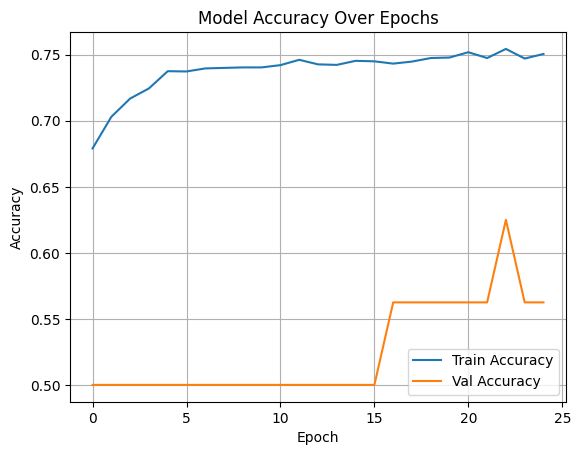

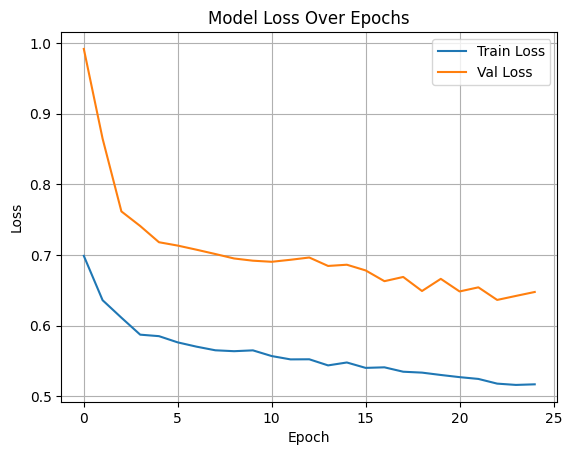

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Predict a Single Test Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


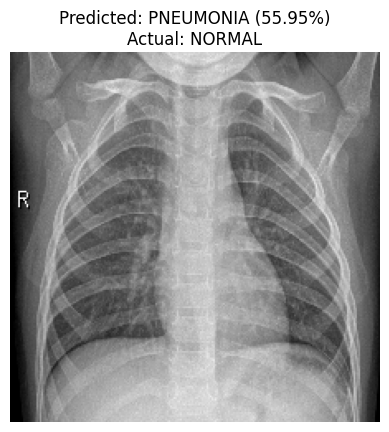

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import random
import os

# Pick a random image from the test set
category = random.choice(['PNEUMONIA', 'NORMAL'])
folder = os.path.join(test_dir, category)
filename = random.choice(os.listdir(folder))
img_path = os.path.join(folder, filename)

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0][0]
predicted_label = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
confidence = prediction if prediction > 0.5 else 1 - prediction

# Display
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence*100:.2f}%)\nActual: {category}")
plt.show()
